In [1]:
import torch
from pathlib import Path

from latent.vae.vae_lightning_module import VAE
import hydra
import yaml
from omegaconf import DictConfig, OmegaConf

from WD.datasets import Conditional_Dataset_Zarr_Iterable
from munch import Munch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
experiment = "vae_b1e-2.yaml"
config_path = f"/data/compoundx/WeatherDiff/config/training/experiment/{experiment}"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
config["experiment"] = experiment
config = Munch.fromDict(config)
config

Munch({'data': Munch({'template': 'geopotential_500', 'ds_format': 'zarr', 'train_shuffle_chunks': True, 'train_shuffle_in_chunks': True, 'val_shuffle_chunks': False, 'val_shuffle_in_chunks': False}), 'vae': Munch({'dim': None, 'type': 'input', 'beta': 0.001, 'batch_size': 128, 'lr': 0.001, 'lr_scheduler_name': 'ReduceLROnPlateau', 'num_workers': 1, 'channel_mult': [1, 1]}), 'training': Munch({'max_steps': 50000000, 'ema_decay': 0.9999, 'limit_val_batches': 10, 'accelerator': 'cuda', 'devices': -1}), 'experiment': 'vae_b1e-3.yaml'})

In [3]:
ds_config_path = "/data/compoundx/WeatherDiff/config_file/template_geopotential_500.yaml"

with open(ds_config_path, 'r') as f:
    ds_config = yaml.safe_load(f)
ds_config = Munch.fromDict(ds_config)
ds_config

Munch({'data_specs': Munch({'conditioning_time_step': [0, -1], 'spatial_resolution': '5.625deg', 'max_chunksize': 1.0, 'conditioning_vars': Munch({'geopotential': Munch({'level': [50, 250, 500, 600, 700]})}), 'delta_t': 6, 'lead_time': 12, 'output_vars': Munch({'geopotential': Munch({'level': [500]})}), 'constants': ['orography']}), 'exp_data': Munch({'test': Munch({'start': datetime.datetime(2017, 1, 1, 0, 0), 'end': datetime.datetime(2018, 12, 31, 0, 0)}), 'train': Munch({'start': datetime.datetime(1979, 1, 2, 0, 0), 'end': datetime.datetime(2015, 12, 31, 0, 0)}), 'val': Munch({'start': datetime.datetime(2016, 1, 1, 0, 0), 'end': datetime.datetime(2016, 12, 31, 0, 0)})}), 'file_structure': Munch({'dir_WeatherBench': '/data/compoundx/WeatherBench/', 'dir_model_input': '/data/compoundx/WeatherDiff/model_input/'})})

In [12]:
model_path = Path("/data/compoundx/WeatherDiff/saved_model/geopotential_500/vae_b1e-3/2023-08-15_13-57-21/lightning_logs/version_0/checkpoints")
model_ckpt = [x for x in model_path.iterdir()][0]

In [13]:
train_ds_path = "/data/compoundx/WeatherDiff/model_input/" + f"{config.data.template}_train.zarr"
train_ds = Conditional_Dataset_Zarr_Iterable(train_ds_path, ds_config, shuffle_chunks=config.data.train_shuffle_chunks, 
                                                shuffle_in_chunks=config.data.train_shuffle_in_chunks)

val_ds_path = "/data/compoundx/WeatherDiff/model_input/" + f"{config.data.template}_val.zarr"
val_ds = Conditional_Dataset_Zarr_Iterable(val_ds_path, ds_config, shuffle_chunks=config.data.val_shuffle_chunks, shuffle_in_chunks=config.data.val_shuffle_in_chunks)


In [14]:
test_ds_path = "/data/compoundx/WeatherDiff/model_input/" + f"{config.data.template}_test.zarr"
test_ds = Conditional_Dataset_Zarr_Iterable(test_ds_path, ds_config, shuffle_chunks=config.data.train_shuffle_chunks, 
                                                shuffle_in_chunks=config.data.train_shuffle_in_chunks)

dl = DataLoader(test_ds, batch_size=config.vae.batch_size)

In [15]:
in_shape = (11,32,64)

In [16]:
model = VAE.load_from_checkpoint(model_ckpt, map_location="cpu", inp_shape = in_shape, train_dataset=train_ds, valid_dataset=val_ds, 
            dim=config.vae.dim, 
            channel_mult = config.vae.channel_mult, 
            batch_size = config.vae.batch_size, 
            lr = config.vae.lr, 
            lr_scheduler_name=config.vae.lr_scheduler_name, 
            num_workers = config.vae.num_workers, 
            beta = config.vae.beta,
            data_type = config.vae.type)

In [17]:
config

Munch({'data': Munch({'template': 'geopotential_500', 'ds_format': 'zarr', 'train_shuffle_chunks': True, 'train_shuffle_in_chunks': True, 'val_shuffle_chunks': False, 'val_shuffle_in_chunks': False}), 'vae': Munch({'dim': None, 'type': 'input', 'beta': 0.001, 'batch_size': 128, 'lr': 0.001, 'lr_scheduler_name': 'ReduceLROnPlateau', 'num_workers': 1, 'channel_mult': [1, 1]}), 'training': Munch({'max_steps': 50000000, 'ema_decay': 0.9999, 'limit_val_batches': 10, 'accelerator': 'cuda', 'devices': -1}), 'experiment': 'vae_b1e-3.yaml'})

In [22]:
x_list = []
r_list = []
mu_list = []

for i, batch in enumerate(dl):

    r, x, mu, _ = model(batch, i)

    x_list.append(x.numpy())
    r_list.append(r.numpy())
    mu_list.append(mu.numpy())


In [23]:
x = np.vstack(x_list)
r = np.vstack(r_list)
mu = np.vstack(mu_list)



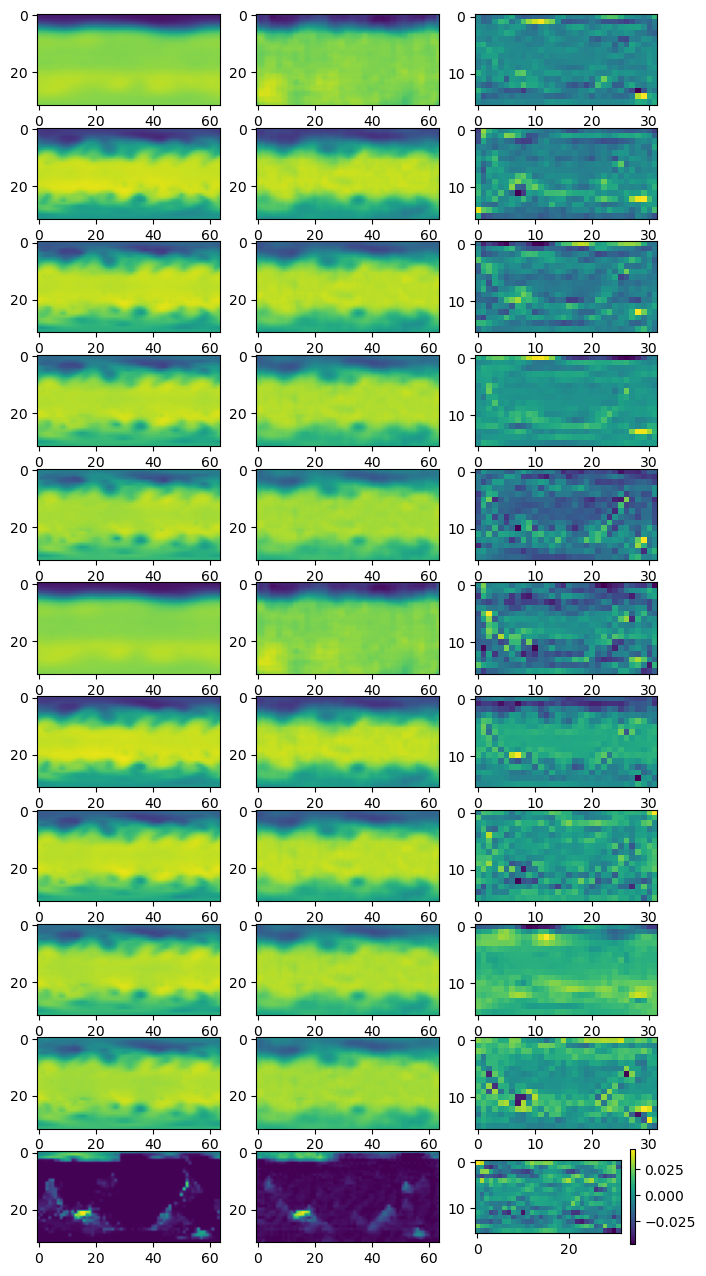

In [29]:
f, axes = plt.subplots(11,3, figsize=(8, 16))

for i in range(11):
    axes[i, 0].imshow(x[100,i], vmin = 0, vmax=1)
    axes[i, 1].imshow(r[100,i], vmin = 0, vmax=1)
    im = axes[i, 2].imshow(mu[100,i])

plt.colorbar(im)

In [30]:
mu.shape

(2904, 11, 16, 32)

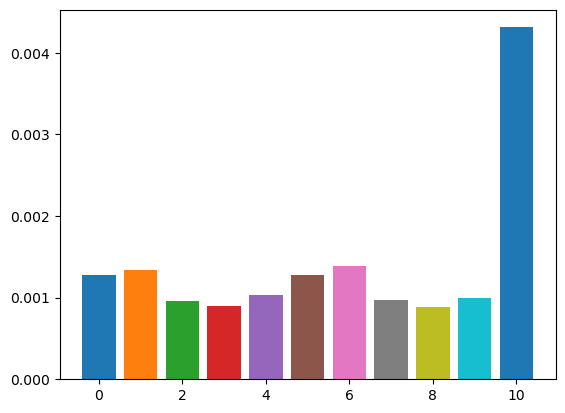

In [21]:
f, ax = plt.subplots(1,1)

mse = np.square(x-r).mean(axis=(0, 2, 3))

for i in range(11):
    ax.bar(i, mse[i] )